# 15分でわかるQCoDes

この短い紹介は、潜在的あるいは新規のユーザーが、本ソフトウェアの感触を得るために作られています。ここでは、ダミーの計器を使用して単純な測定を実行します。QCoDeSを使用した最初のコードを開始する前に、[この文章](../start/index.rst#installation)で説明されているように、Python環境を適切に設定していることを確認してください。このノートブックをインタラクティブにフォローしたい場合は、[GitHubからダウンロード](https://github.com/QCoDeS/Qcodes/blob/main/docs/examples/15_minutes_to_QCoDeS.ipynb)してローカルシステムで実行するか、または "launch binder" リンクを使用してWebインターフェース経由で使用することができます。


## Introduction

QCoDeSは、ナノエレクトロニクスの実験を促進するための、Pythonベースのデータ収集・処理フレームワークです。高度にカスタム可能なオープンソースプロジェクトとして、このシステムは多様な実験セットアップのニーズに適合し、コミュニティ全体の実験作業のための共通システムとして機能することを期待しています。

本記事は、QCoDeSの実用的な概要を提供し、インストールから実験データの取り扱いまでを1冊のノートブックにまとめたものです。途中には、このソフトウェアの機能をあなたの実験用に設定するために役立つリンクが用意されています。

## Installation

QCoDeSは、pipまたはcondaパッケージマネージャを使って、お好みの環境に簡単にインストールできます。その他のインストール方法については、[インストールガイド](../start/index.rst#installation)をご参照ください。

pip 経由でインストールします：


> pip install qcodes

conda 経由でインストールします：

> conda -c conda-forge install qcodes


## モジュールのインポート

QCoDeSには様々なモジュールが用意されていますが、この例では単純な測定において必要なものだけをインポートします。

In [1]:
import numpy as np

import qcodes as qc

## Multidimensional scanning module
from qcodes.dataset import (
    LinSweep,
    Measurement,
    dond,
    experiments,
    initialise_or_create_database_at,
    load_by_run_spec,
    load_or_create_experiment,
    plot_dataset,
)

## Dummy instruments for generating synthetic data
from qcodes.instrument_drivers.mock_instruments import (
    DummyInstrument,
    DummyInstrumentWithMeasurement,
)

## Using interactive widget
from qcodes.interactive_widget import experiments_widget

## Instruments

Instrument クラス

QCoDeSのInstrumentクラスは、ハードウェアへの接続機能を担保し、内蔵メソッドで計測器を制御します。計測器クラスの詳細については、[こちらの詳細説明](writing_drivers/Instruments.ipynb)または対応する[apiドキュメント](../api/instrument/index.rst)を参照してください。

例として、まずはふたつのダミーインストゥルメントを作製します。

- 2チャンネルのデジタル-アナログコンバーター(`dac`)
- 生成された信号を測定するデジタル・マルチメーター(`dmm`)

In [2]:
# A dummy signal generator with two parameters ch1 and ch2
dac = DummyInstrument('dac', gates=['ch1', 'ch2'])

# A dummy digital multimeter that generates a synthetic data depending
# on the values set on the setter_instr, in this case the dummy dac
dmm = DummyInstrumentWithMeasurement('dmm', setter_instr=dac)

すべての計器は、コンフィギュレーションを検査するためのメソッドを備えています。これを``スナップショット``と呼びます。デジタル・マルチメーターの例で垣間見えるように、メソッドは人間が読めるバージョンとして提供されます。：（翻訳要検討）

In [3]:
dmm.print_readable_snapshot()

dmm:
	parameter value
--------------------------------------------------------------------------------
IDN :	None 
v1  :	0 (V)
v2  :	0 (V)


見ての通り、我々のダミーマルチメーター `dmm` は、ふたつのパラメーター (`Parameters`) v1, v2 を持っています。これらはダミーシグナルジェネレーター(`dac`)が持つふたつのチャンネルに対応します。

## Parameters

QCoDeSにおける `Parameter` は、インストゥルメントに依存する値で、メソッドを通して値を取得したり設定したりできます。直感的には、`Parameter` は、QCoDeS がほとんどの計測器と通信するために用いられる方法です。例えば、デジタルマルチメーターは設定(例：モード、レンジ)を必要とし、データ(例：電圧、電流)を提供します。これらのメソッドは、 [parameter API](../api/parameters/index.rst)を利用する[instrument drivers](index.rst#drivers)によって定義されています。

この例では、合成データを生成するために、`set` 及び`get`メソッドを活用してダミーインストゥルメントを使用しています。

`dac` においては、`DummyInstrument` クラスのインスタンス化でこれらの設定可能な `Parameter `が追加されます（`ch1`と`ch2`に対応しています）。

> dac = DummyInstrument('dac', **gates=['ch1', 'ch2']**)

同様に、ダミーのデジタル・マルチメーターである`dmm`は、セッター計測器（setter_instr, つまり`dac`）の出力チャンネルで定義された`DummyInstrumentWithMeasurement`クラスのインスタンス化によって、取得可能な`Parameter`が追加されます。

> dmm = DummyInstrumentWithMeasurement('dmm', **setter_instr=dac**)

Instrumentsのインスタンス化の方法は異なる（例えば`dac`ならgates、`dmm`ならsetter_instrのように）場合がありますが、`Parameter`自体ははQCoDeSの測定に共通するインターフェースです。

QCoDesでは利便性のため、広範な測定器に対応可能な様々なparameterクラスを提供しています。

   - `Parameter` : 与えられた時刻における単一の値を表します (例. 電圧, 電流値)。詳細は[example parameter notebook](Parameters/Parameters.ipynb)より。
   
   - `ParameterWithSetpoints`: 一度に返される、すべて同じ型からなる値の配列を返します(例. 電圧対時間の波形)。詳細は[parameter with setpoint notebook](Parameters/Simple-Example-of-ParameterWithSetpoints.ipynb)より。

   - `DelegateParameter`: 他のparameterをプロキシするためのクラス。詳細は[parameter API](../api/parameters/index.rst)より。Delegated parameterでは、ソースとなるパラメーターとは異なるラベルや単位を利用できます。

これらのビルト・イン・パラメータークラスは、典型的には計測器通信のラッパー（※訳者註: 直接の取り扱いが複雑あるいは困難になる昨日を簡便な形でユーザーに提供するもの）として用いられます。 ユーザー向けの`set`メソッドと`get`メソッドは、計測器向けの`set_raw`メソッドと`get_raw`メソッドを呼び出します。これらのパラメーターのより詳細な例は、[notebook on Parameters](index.rst#parameters)で説明されています。 

### パラメーターの設定・取得の例

ほとんどの場合、設定可能なパラメータは、単純な関数の引数としてその値を受け取ります。この例では、シグナルジェネレーター`dac`の`ch1 パラメーターに 1.1 という値を設定しています：

In [4]:
dac.ch1(1.1)

同様に、値を取得可能なパラメーターは、多くの場合、簡単な関数が呼び出されることを通してその値が返されます。この例では、デジタルマルチメーター`dmm`の値を以下のように読み取っています:

In [5]:
dmm.v1()

3.990052278971744

## Stations  

ステーションとは、実験に使われているすべてのインストゥルメントやデバイスを集めたものです。前述の通り、ステーションは`Instruments`や`Parameters`及びその他の要素を追加できるバケット（集合体）と見なすことができます。
これらの用語はそれぞれ QCoDeS では明確な意味を持ち、後のセクションで説明します。ステーションが適切に設定されると、そのインスタンスを使ってこれらの要素(`Instruments`や`Parameters`など)にアクセスすることができます。詳細については[Station](Station.ipynb)を参照してください。

前に構成したインストゥルメント(dac, dmmなど)を組織化するために、まず以下のようにステーションのインスタンスを宣言します:

In [6]:
station = qc.Station()

### ステーションへのインストゥルメントの追加

実験中用いられるすべてのインストゥルメントは、`Station`に追加されるのが望ましいです。  

ここでは、`dac`及び`dmm`を、`add_component()`メソッドを用いてステーションに追加します: 

In [7]:
station.add_component(dac)
station.add_component(dmm)

'dmm'

### ステーションの調査

どのような実験でも、装置(Instrument)のセットアップを記録することは不可欠です。これを可能にするために、`Station`クラスでは`snapshot`メソッドが提供されています。このメソッドは、ステーション内の`Instruments`やその性質(`Parameters`など) を再帰的に取得します.

このデータは通常、QCoDeSで実験が実行されるたびに保存されますが、ステーションの状態を調査するために、`snapshot`メソッドを使用することもできます：


In [8]:
# Remove the ``_ = `` part to see the full snapshot
_ = station.snapshot()

これは実際には長い出力になります。このチュートリアルでは省略しますが、ネストされた辞書は、ステーションとその付属する装置（Instrument）について、人間にも機械にも読める説明を提供します：

```
{'instruments': {'dmm': {'functions': {},
   'submodules': {},
   '__class__': 'qcodes.instrument_drivers.mock_instruments.DummyInstrumentWithMeasurement',
   'parameters': {'IDN': {'__class__': 'qcodes.instrument.parameter.Parameter',
    [...]
     'inter_delay': 0,
     'instrument': 'qcodes.instrument_drivers.mock_instruments.DummyInstrumentWithMeasurement',
     'instrument_name': 'dmm',
     'unit': ''},
    'v1': {'__class__': 'qcodes.instrument_drivers.mock_instruments.DmmExponentialParameter',
     'full_name': 'dmm_v1',
     'value': 5.136319425854842,
     'raw_value': 5.136319425854842,
     'ts': '2021-03-29 18:47:16',
     'label': 'Gate v1',
     'name': 'v1',
     'post_delay': 0,
     'vals': '<Numbers -800<=v<=400>',
     'inter_delay': 0,
     'instrument': 'qcodes.instrument_drivers.mock_instruments.DummyInstrumentWithMeasurement',
     'instrument_name': 'dmm',
     'unit': 'V'},
     [...]
```

### Saving and loading configurations.

測定器のインスタンス化、つまり適切なパラメータの初期値設定や、測定に関する同様の初期設定は、コードの初期化部分を構成します。一般的に、この部分は非常に長くなり、維持するのが大変になります。これらの(あるいはそれ以上の)懸念は `Station` オブジェクトの[YAML 設定ファイル](Station.ipynb#Using-Station-with-YAML-configuration-files)によって解決できます。ステーションに関する更なるオプションの詳細については[ステーションの例](Station.ipynb#Default-Station)をご覧ください。

## Databases and experiments.

`Station`が使えるようになったので、次のステップでは、データを保存するための`データベース`のセットアップをします。QCoDesでは、これを実現するためにSQLite3データベースを活用しています。

### データベースの初期化または生成

測定を開始する前に、まずデータベースの初期化を行います。データベースの格納場所は、QCoDesにインストールされた設定オブジェクトによって決定します。データベースは、現在使用されているQCoDeSバージョンに準拠した最新のサポートバージョンで作成されます。データベースが既に存在し、QCoDeSのアップグレードが行われている場合、そのデータベースは引き続き使用することができ、最初の接続時に自動的に最新バージョンにアップグレードされます。

データベースの特定の場所への初期化（または作成）は、以下の静的関数によって実現されます:

In [9]:
initialise_or_create_database_at("~/experiments_for_15_mins.db")

デフォルトでは、QCoDesがサポートするアクティブなデータベースは1つのみです。現在のデータベースの格納場所は、設定データ(例: qcodes.config)内に保存されています。 

In [10]:
qc.config.core.db_location

'~/experiments_for_15_mins.db'

### experimentオブジェクトのロードまたは作成

データベースを初期化したので、今度は`Experiment`オブジェクトを作成しましょう。このオブジェクトには実験やサンプルの名前が含まれ、測定中に入手したデータのマネージャーとして機能します。`load_or_create_experiment`関数は、既存の同名の実験(`Experiment`オブジェクト)を呼び出します。そのような実験が見つからなかった場合、新しい`Experiment`メソッドが作成されます。

以下の例では、`tutorial_exp`という名称の実験を呼び出しています:


In [11]:
tutorial_exp = load_or_create_experiment(
    experiment_name="tutorial_exp",
    sample_name="synthetic data"
)

`experiment`オブジェクトのためのデータベースのpathは、QCoDeSの設定(configuration)内で定義されています. はじめに、`Experiment`はそのパス内にあるデータベース(あるいは、同一パス内にデータベースがなければ新規に作成されたデータベース)をロードし、その後そのデータベース内に、ここで作成された実験を保存します. この名前とサンプル名を持つ実験がすでに存在する場合、これが残りのセッションのデフォルト実験として設定されます。実験と一緒にデータベースをロードしたり作成したりすることはユーザーに優しい機能ではありますが、先に示したように、データベースを初期化することを推奨します。これによって、実験とデータベースをより制御して測定することができ、データ管理における予期せぬ結果を避けることができます。

上記の実験（experiment）のロードや作成の方法は、最も汎用性の高いものです。しかし、データベースに関するガイドで述べられているように、他のオプションも存在します。

## Measurement Context Manager

`Measurement` オブジェクトは QCoDeS 内の計測器からデータを取得するために使用されるものであり、`experiment`（データを処理するためのオブジェクト）と`station`（計測器を制御するためのオブジェクト）の両方を指定してインスタンス化されます。これらの引数がない場合、最新の実験とステーションがデフォルトとして使用されます。キーワード引数 `name` には任意の文字列を指定することができます。

In [12]:
context_meas = Measurement(exp=tutorial_exp, station=station, name='context_example')

experimentを生成したりロードしたりする前に `measurement` をインスタンス化することは可能ですが、これはお勧めできません。

1. 初期化された `database` に `experiment` が含まれていない場合、インスタンス化でエラーが発生し、作業が中断されます。
2. データベースに既に `experiment` が含まれている場合、インスタンス化された `measurement` はエラーメッセージや警告を表示することなく、データベース内の最新の `experiment` に追加されます。これはデータ管理の不備につながります。


### 測定パラメーターの登録

QCoDeSはパラメータ間の関係（パラメーター `y` は `x` に依存する）を保存する機能を備えています。この機能により、測定の意図を実験記録に明確に記録することができます。加えて、QCoDeS を使用してデータをプロットする際、パラメーターの依存関係は座標軸の定義に使用されます。測定されるパラメーターは、まず `measurement` で登録されます。従属するパラメーター（つまり y(x)）を登録するときに、独立パラメータは設定値として宣言されます。結果として、独立パラメーターは、対応する従属パラメーターよりも前に登録されなければなりません。


以下の例では、``dac.ch1``は独立パラメーターです。よって、``dmm.v1``は``dac.ch1``のセットポイントとして登録されています。 

In [13]:
# Register the independent parameter...
context_meas.register_parameter(dac.ch1)
# ...then register the dependent parameter
context_meas.register_parameter(dmm.v1, setpoints=(dac.ch1,))

### 測定ループ処理の一例

QCoDeSのmeasurementモジュールは、測定するパラメーターを登録し、結果を保存するためのコンテキスト・マネージャーを提供します。コンテキスト・マネージャー内では、測定されたデータはバックグラウンド・プロセスとして定期的にデータベースに保存されます。

簡単な計測を行うには、コンテキスト・マネージャー内に簡単なループを作成し、計測器を制御し、データを取得し、結果を保存します。

> 以下は、QCodesにおいてデータを取得するためのよりユーザーによる設定が可能なアプローチです。より多くの具体例や詳細については、 [Performing measurements using QCoDeS parameters and DataSet example](./DataSet/Performing-measurements-using-qcodes-parameters-and-dataset.ipynb)を御覧ください。


In [14]:
# Time for periodic background database writes
context_meas.write_period = 2

with context_meas.run() as datasaver:
    for set_v in np.linspace(0, 25, 10):
        dac.ch1.set(set_v)
        get_v = dmm.v1.get()
        datasaver.add_result((dac.ch1, set_v),
                             (dmm.v1, get_v))

    # Convenient to have for plotting and data access
    dataset = datasaver.dataset

Starting experimental run with id: 1. 


`meas.run`メソッドはデータの取得と保存を制御するためのコンテキストマネージャーを返します。コンテキストに入ると `DataSaver` オブジェクトが得られるので、これを `datasaver` 変数に格納します。単純なループ構造を使って、計測器の `set` メソッドと `get` メソッドを使って、それぞれ計測器の制御とデータの取得を行っています。次に、``add_result`` メソッドを使用して、すべてのデータポイントのサイズを検証し、書き込みキャッシュに断続的に格納します。測定の書き込み期間ごとに、このキャッシュのデータはバックグラウンドでデータベースに排出されます。

## Using the doNd multi-dimensional measurement utility 

Qcodesには、[optimized data handling](DataSet/Using_doNd_functions_in_comparison_to_Measurement_context_manager_for_performing_measurements.ipynb)で多次元データセットを生成する関数も含まれています。このうち、`dond`（do n-dimentional）メソッドは、多次元データの収集を容易にします。同様の最適化はmesurementのコンテキストを使用して行うこともできますが（[measuring with shaped data](DataSet/Performing-measurements-using-qcodes-parameters-and-dataset.ipynb#Specifying-shape-of-measurement)を参照）、このアプローチはコードのセットアップを簡易化し、可読性を向上します。

> これは、多次元データをQCoDeSで得るためのよりユーザーフレンドリーな方法です。

まずはじめに、各独立パラメーターについてのスイープ処理によって定義した測定をセットします。我々のケースでは、``dac``のふたつのチャンネルを使用しています:

In [15]:
# Setting up a doNd measurement
sweep_1 = LinSweep(dac.ch1, -1, 1, 20, 0.01)
sweep_2 = LinSweep(dac.ch2, -1, 1, 20, 0.01)


`dac.ch1`及び`dac.ch2`の線形掃引は、掃引の起終点(-1 to 1 V)、ステップ数(20)並びに各ステップ間のdelay time(0.01 s)によって定義されます。このdelay timeは、実際の測定機器が掃引の各ステップ間において平衡に到ることができるように使われます。QCoDeSには、様々なサンプリング方式を可能にするために、[複数のタイプのスイープ方式が含まれています](DataSet/Using_doNd_functions_in_comparison_to_Measurement_context_manager_for_performing_measurements.ipynb)。

> `dond` を使用する場合、パラメータの登録は行いません。`dond` では、あらゆる依存パラメータがすべてのスイープパラメータに依存します。

In [16]:
dond(
    sweep_1,                          # 1st independent parameter
    sweep_2,                          # 2nd independent parameter
    dmm.v1,                           # 1st dependent parameter
    dmm.v2,                           # 2nd dependent parameter
    measurement_name="dond_example",  # Set the measurement name
    exp=tutorial_exp,                 # Set the experiment to save data to.
    show_progress=True                # Optional progress bar
)

Starting experimental run with id: 2. Using 'qcodes.dataset.dond'


  0%|          | 0/400 [00:00<?, ?it/s]

(dond_example #2@/Users/ezmario/experiments_for_15_mins.db
 ---------------------------------------------------------
 dac_ch1 - numeric
 dac_ch2 - numeric
 dmm_v1 - numeric
 dmm_v2 - numeric,
 (None,),
 (None,))

`dond`関数は、多くのオプション（プロット、データベース書き込み期間、マルチスレッドなど）を備えており、[example notebooks](DataSet/Using_doNd_functions_in_comparison_to_Measurement_context_manager_for_performing_measurements.ipynb#Handling-plot,-experiment,-and-measurement_name-with-doNd)でさらに詳しく説明しています。単純な計測の場合、[do1d](DataSet/Using_doNd_functions_in_comparison_to_Measurement_context_manager_for_performing_measurements.ipynb#do1d)と[do2d](DataSet/Using_doNd_functions_in_comparison_to_Measurement_context_manager_for_performing_measurements.ipynb#do2d)は、1次元と2次元の計測で同様の機能を持つ、よりシンプルなインターフェースを提供します。

## Exploring datasets and databases

このセクションでは、`DataSets` を利用して作業するための方法と関数について詳しく説明します。QCoDeSでは、すべての測定結果は一般的に`DataSet`オブジェクトとしてパッケージ化され、データベースに格納されます。QCoDeSを実行するためには必須ではありませんが、新しいデータ解析方法を開発するユーザーをサポートするために[detailed walktrough notebook](DataSet/DataSet-class-walkthrough.ipynb)を提供しています。


### データベース内のすべてのdatasetsの列挙

我々のデータを取得する最も直接的な方法は、`experiments`関数を使用することです; これにより、現在初期化されている`database`が呼び出され、内部に含まれている`experiments`と`datasets`が表示されます。

In [17]:
experiments()

[tutorial_exp#synthetic data#1@/Users/ezmario/experiments_for_15_mins.db
 -----------------------------------------------------------------------
 1-context_example-1-dac_ch1,dmm_v1-10
 2-dond_example-2-dac_ch1,dac_ch2,dmm_v1,dmm_v2-800]

この例のデータベースにはわずかな実験しか含まれていませんが、ナノエレクトロニクスデバイスで測定を行うと、この数は大幅に増加する可能性があります。

実際のデータベースには、多くの実験が含まれ、それぞれの実験には多くのデータセットがあります。しばしば、特定の実験からデータセットを読み込んでさらなる分析を行いたいことがあります。ここでは、データベースから既に測定されたデータセットを見つけて取得するさまざまな方法を探ってみましょう。

### 単一の実験に含まれるすぺてのdatasetsの列挙

experimentは、`measurements`オブジェクトによって作られた`datasets`も含んでいます。`data_sets`メソッドを使用することで、これらのデータセット、記録されたパラメータ、および各パラメータのデータの種類を出力できます。

In [18]:
tutorial_exp.data_sets()

[context_example #1@/Users/ezmario/experiments_for_15_mins.db
 ------------------------------------------------------------
 dac_ch1 - numeric
 dmm_v1 - numeric,
 dond_example #2@/Users/ezmario/experiments_for_15_mins.db
 ---------------------------------------------------------
 dac_ch1 - numeric
 dac_ch2 - numeric
 dmm_v1 - numeric
 dmm_v2 - numeric]

### 1つ以上の指定を使ってdatasetをロードする

データをプロットまたは解析するためには、`datasets`を取得する必要があります。これは`experiment`から直接行うことができますが、通常はinstrument環境は分析には使用されません。さらに、別々の`experiments`からデータを比較したい場合、データセットを個別に読み込む必要があります。

QCoDeSでは、`load_by_run_spec`関数を使用して簡単な基準で`datasets`を取得できます。この例では、名前とデータベースID番号によって以前の1Dおよび2Dデータセットを読み込みます。


In [19]:
dataset_1d = load_by_run_spec(experiment_name='tutorial_exp', captured_run_id=1)
dataset_2d = load_by_run_spec(experiment_name='tutorial_exp', captured_run_id=2)

引数は任意ですが、指定された仕様に一致するrunが複数見つかった場合、関数呼び出しはエラーを発生する。このようなエラーが発生した場合、トレースバックにはrunの仕様も含まれます。データ抽出のための詳細な検索基準の例は、この[example notebook](DataSet/Extracting-runs-from-one-DB-file-to-another.ipynb#Uniquely-identifying-and-loading-runs)に記載されています。


### datasetsのプロット

数値データは通常、表にしてしまうと理解しにくいので、プロットとして視覚化するのが理想です。QCoDeS には `plot_dataset` というプロット関数があり、1次元と2次元の `dataset` をきれいに可視化することができます:

([<Axes: title={'center': 'Run #1, Experiment tutorial_exp (synthetic data)'}, xlabel='Gate ch1 (V)', ylabel='Gate v1 (V)'>],
 [None])

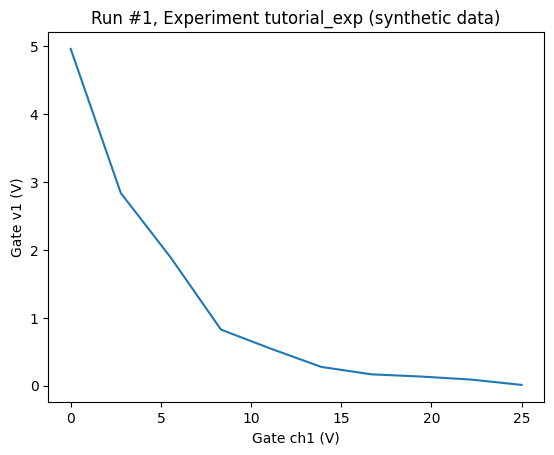

In [20]:
# Plotting 1d dataset
plot_dataset(dataset_1d)

1dのデータでは、単純な折れ線グラフが生成され、依存パラメータと独立パラメータがそれぞれのX軸とY軸に設定されます。これは、(単位を提供する)`instrument`と、測定された`parameters`間の事前定義された依存関係の統合によってうまく機能します。

([<Axes: title={'center': 'Run #2, Experiment tutorial_exp (synthetic data)'}, xlabel='Gate ch1 (V)', ylabel='Gate ch2 (V)'>,
  <Axes: title={'center': 'Run #2, Experiment tutorial_exp (synthetic data)'}, xlabel='Gate ch1 (V)', ylabel='Gate ch2 (V)'>],
  <matplotlib.colorbar.Colorbar at 0x12c8a3d40>])

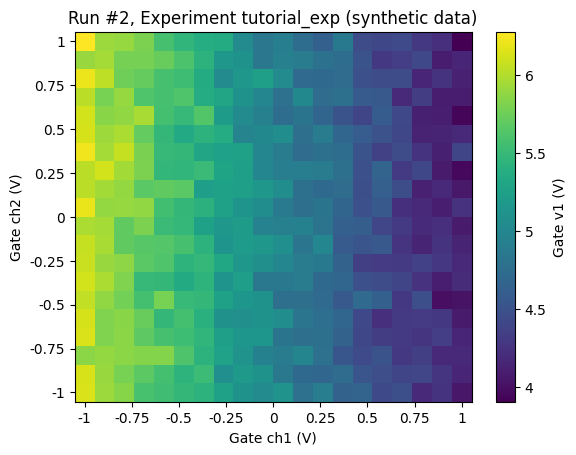

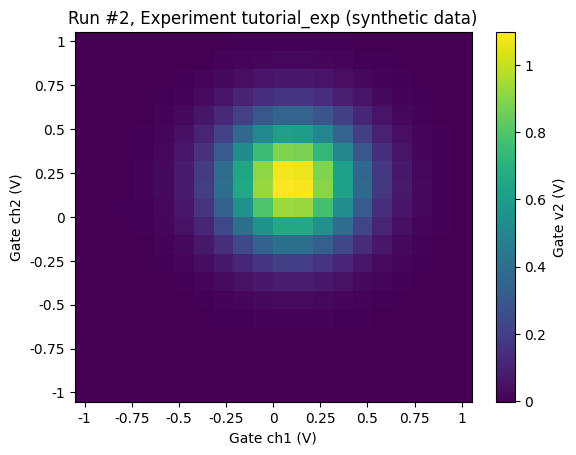

In [21]:
# Plotting 2d dataset as heatmaps
plot_dataset(dataset_2d)

2次元データでは、独立パラメータをX軸とY軸に設定し、従属パラメータをカラースケールに設定したヒートマップが生成されます。1次元の場合と同様、この自動可視化は、`dond`関数に提供された定義済みの`parameters`に依存します。

> QCoDeSのdatasetsをプロットするより詳細な事例については、様々なデータタイプをカバーした以下の記事が用意されています:
>
> - [Offline plotting tutorial](DataSet/Offline%20Plotting%20Tutorial.ipynb)
> - [Offline plotting with categorical data](DataSet/Offline%20plotting%20with%20categorical%20data.ipynb)
> - [Offline plotting with complex data](DataSet/Offline%20plotting%20with%20complex%20data.ipynb)

### Plottrを用いたQCoDeS測定のライブプロッティング

PlottrはQCoDeS測定のライブプロッティングをサポートし、推奨しています。これにより、進行中の測定を直接視覚化することができ、実験者の便宜を図ることができます。詳細は[How to use plottr with QCoDeS for live plotting](plotting/How-to-use-Plottr-with-QCoDeS-for-live-plotting.ipynb)ノートブックに記載されています。

### datasetの特定のパラメーターのデータを取得

ナノエレクトロニクス測定のための新しい解析手法を設計するとき、データセットで得られた個々のパラメータからデータを抽出することが有用な場合があります。`DataSet`に含まれる `get_parameter_data`メソッドを使用すると、1つのパラメーターのデータを辞書型で得ることができます。

> このメソッドは、独立パラメータ（`dac_ch1` など）と従属パラメータ（`dmm_v1` など）では動作が異なることに注意してください:

In [22]:
# All data for all parameters
dataset_1d.get_parameter_data()

{'dmm_v1': {'dmm_v1': array([4.96233755, 2.83914371, 1.88493966, 0.82608967, 0.54397689,
         0.27727591, 0.16763785, 0.13458801, 0.08989949, 0.01153642]),
  'dac_ch1': array([ 0.        ,  2.77777778,  5.55555556,  8.33333333, 11.11111111,
         13.88888889, 16.66666667, 19.44444444, 22.22222222, 25.        ])}}

In [23]:
# Data for independent parameter
dataset_1d.get_parameter_data('dac_ch1')

{'dac_ch1': {'dac_ch1': array([ 0.        ,  2.77777778,  5.55555556,  8.33333333, 11.11111111,
         13.88888889, 16.66666667, 19.44444444, 22.22222222, 25.        ])}}

In [24]:
# Data for dependent parameter
dataset_1d.get_parameter_data('dmm_v1')

{'dmm_v1': {'dmm_v1': array([4.96233755, 2.83914371, 1.88493966, 0.82608967, 0.54397689,
         0.27727591, 0.16763785, 0.13458801, 0.08989949, 0.01153642]),
  'dac_ch1': array([ 0.        ,  2.77777778,  5.55555556,  8.33333333, 11.11111111,
         13.88888889, 16.66666667, 19.44444444, 22.22222222, 25.        ])}}

`get_parameter_data`メソッドに関するより詳細な情報については[exporting data section of the performing measurements using QCoDeS parameters and dataset](DataSet/Performing-measurements-using-qcodes-parameters-and-dataset.ipynb#Accessing-and-exporting-the-measured-data)および[Accessing data in DataSet notebook](DataSet/Accessing-data-in-DataSet.ipynb)を参照してください。

### pandas dataframeへのデータのエクスポート

同様に、QCoDeS データベース内に保存されたデータは、分析のために pandas データフレームとしてエクスポートすることができます。これは `DataSet` に含まれる `to_pandas_dataframe` メソッドによって実現されます。

In [25]:
df = dataset_1d.to_pandas_dataframe()
df.head()

,dmm_v1
dac_ch1,
0.000000,4.962338
2.777778,2.839144
5.555556,1.884940
8.333333,0.826090
11.111111,0.543977


### xarrayへのデータのエクスポート

QCoDeS の `dataset` 内に保存されているデータを `xarray.DataSet` にエクスポートすることも可能です。これは次のようにして行うことができます:

In [26]:
xr_dataset = dataset_1d.to_xarray_dataset()
xr_dataset

<xarray.Dataset> Size: 160B
Dimensions:  (dac_ch1: 10)
Coordinates:
  * dac_ch1  (dac_ch1) float64 80B 0.0 2.778 5.556 8.333 ... 19.44 22.22 25.0
Data variables:
    dmm_v1   (dac_ch1) float64 80B 4.962 2.839 1.885 ... 0.1346 0.0899 0.01154
Attributes: (12/14)
    ds_name:                  context_example
    sample_name:              synthetic data
    exp_name:                 tutorial_exp
    snapshot:                 {"station": {"instruments": {"dac": {"functions...
    guid:                     386662af-0000-0000-0000-018f29084c7f
    run_timestamp:            2024-04-29 17:46:00
    ...                       ...
    captured_counter:         1
    run_id:                   1
    run_description:          {"version": 3, "interdependencies": {"paramspec...
    parent_dataset_links:     []
    run_timestamp_raw:        1714380360.834736
    completed_timestamp_raw:  1714380360.8378649

より詳細な情報については[example notebook on working with pandas](DataSet/Working-With-Pandas-and-XArray.ipynb) and [Accessing data in DataSet notebook](DataSet/Accessing-data-in-DataSet.ipynb)を御覧ください。

### インタラクティブウィジェットによるデータの検索

テキストベースのレビューにとどまらず、ステーション・スナップショットの閲覧、メモの追加、選択した日のプロット作成などのインターフェイスを備えた、データベースを簡単に探索できるグラフィカル・ウィジェットも搭載されています。

> このウィジェットは、インタラクティブな要素を表示するために[ipywidgets](https://ipywidgets.readthedocs.io/)を用いており、Jupyter notebookでのみ利用可能です。ただし、以下に簡単な非インタラクティブなデモビデオも用意しています。

ここでは、先ほど初期化したサンプル・データベースをロードします。

In [27]:
experiments_widget(sort_by="timestamp")

外見と特徴をまとめた短いビデオはこちら：

![video demo about experiments widget should show here](../_static/experiments_widget.webp)

## Further Reading

### QCoDeS configuration  

QCoDeSはJSONベースの構成システムを使用します。QCoDeSはデフォルトのコンフィギュレーションで提供されます。デフォルトのconfigファイルは上書きしないでください。もし修正した場合は、ホームディレクトリか、スクリプト/ノートブックの現在のワーキングディレクトリに更新されたconfigファイルを保存してください。QCoDeS config システムはまずカレントディレクトリで config ファイルを探し、次にホームディレクトリで config ファイルを探します。デフォルトのコンフィグはqcodes.configにあります。configの変更と保存方法については、[documentation on config](Configuring_QCoDeS.ipynb)を参照してください。


### QCoDeS instrument drivers

現在マイクロソフトステーションで使用されている機器のほとんどをサポートし、ドライバを提供しています。しかし、現在ドライバでサポートされている以上の機能が必要な場合、ドライバをアップデートするか、QCoDeSチームにその機能をリクエストすることができます。また、ドライバの書き方について簡単な概要を知りたい場合は、[このノートブック](writing_drivers/Instruments.ipynb)や[example notebooks on writing drivers](index.rst#writing-drivers)を参照してください。


### QCoDeS logging

すべての測定セッションにおいて、QCoDeSロギングをオンにしておくことを強く推奨します。これにより、トラブルシューティングが必要な場合に、すべてのログを保存することができます。この機能については、すべてのロギング機能を説明した[example notebook](logging/logging_example.ipynb)で詳しく説明しています。
